In [10]:
import pandas as pd
import pickle

In [1]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [63]:
def get_data(sample_size):
    df = pd.read_csv(f"res2/{sample_size}-mergedresults.csv",names=['gamma', 'fPos', 'fNeg'], index_col='gamma', skiprows=1)
    with open(f"res2/{sample_size}-votingnets.pickle", 'rb') as f:
        nn = pickle.load( f)

    sizes = {gamma: len(n.keys()) for gamma, [n] in nn.items()}

    dfs = pd.DataFrame.from_dict(sizes, orient='index', columns=['anchors'])
    return df, dfs

In [85]:
def make_double_plot(df, dfs):
    fig, axs = plt.subplots(2, 1, figsize=(12,10))
    #fig.figure(figsize=(12, 10))
    axs[0].plot(df.fPos,'o-', label='merged: False Pos')
    axs[0].plot(df.fNeg,'o-', label='merged: False Neg')
    axs[0].legend()
    axs[0].set(ylabel='#')

    axs[1].plot(dfs.anchors/1950)
    axs[1].set(xlabel=r'$\gamma$', ylabel='Compression')
    for a in axs.flat:
        a.label_outer()


In [62]:
! ls res2/*.csv

res2/1950-mergedresults.csv res2/4950-mergedresults.csv
res2/450-mergedresults.csv


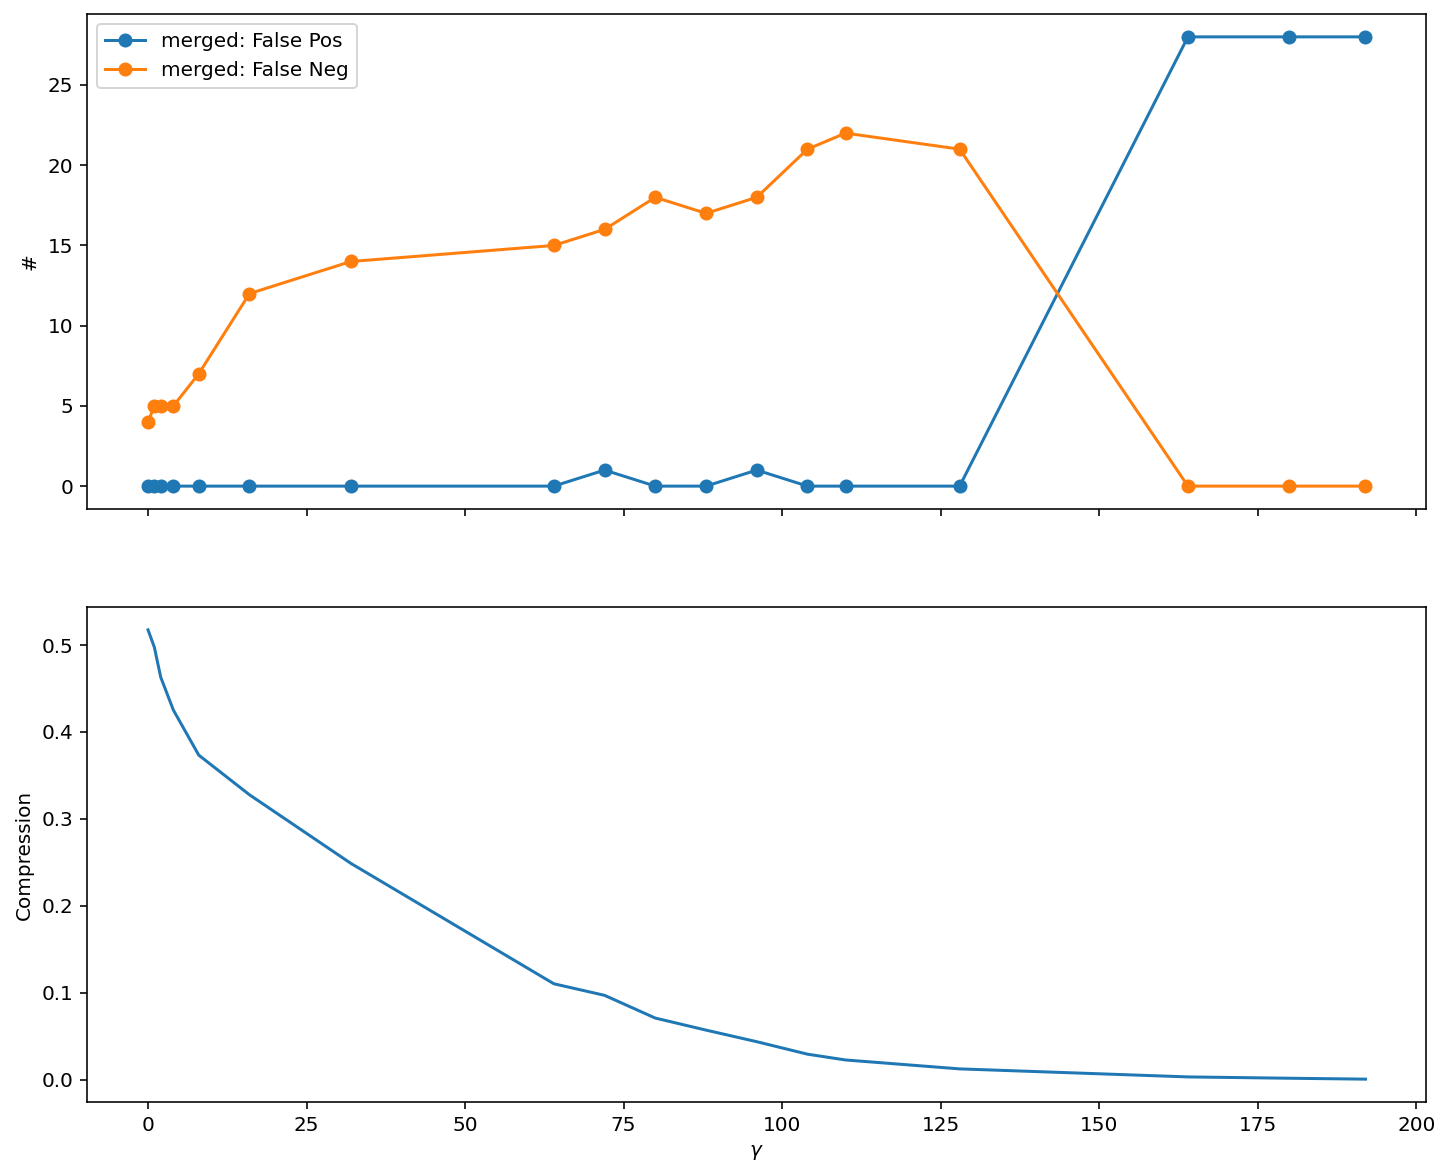

In [83]:
df, dfs = get_data(1950)

make_double_plot(df, dfs)

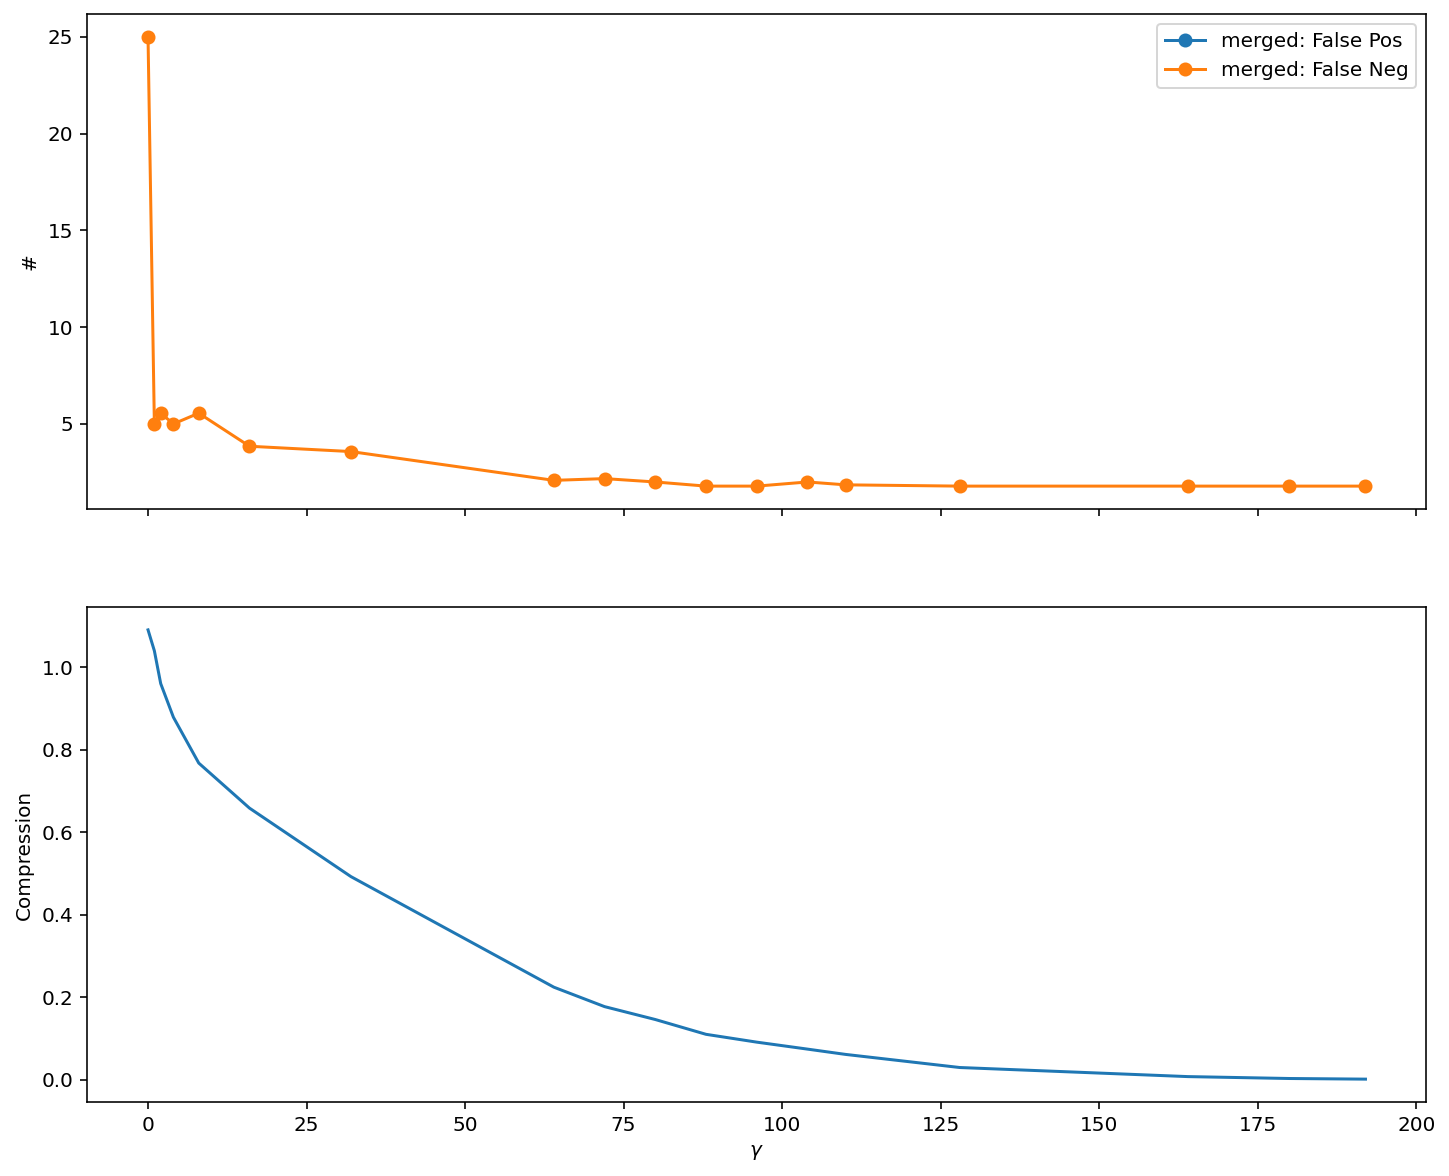

In [86]:
df, dfs = get_data(4950)

make_double_plot(df, dfs)